In [1]:
from typing import SupportsFloat, Any, Optional

from gymnasium import ActionWrapper, Wrapper
from gymnasium.core import WrapperActType, WrapperObsType
from gymnasium.spaces import Box
from gymnasium.wrappers import TimeLimit, RecordVideo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from exp.di.mujoco_exp.learning._2_crawler._0_random_target.crawler import WalkToTargetEnv

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
class RepeatActionsWrapper(Wrapper):
    """
    One step of wrapped = n steps of unwrapped with same action.
    Rewards are averaged.
    """

    def __init__(self, env, steps_to_repeat: int):
        super().__init__(env)
        self.steps_to_repeat = steps_to_repeat
        assert steps_to_repeat > 1

    def step(
            self, action: WrapperActType
    ) -> tuple[WrapperObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        rewards = []
        for i in range(self.steps_to_repeat):
            obs, reward, terminated, truncated, info = self.env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break
        reward = np.mean(rewards)
        return obs, reward, terminated, truncated, info


class SimpleOscillatingPhaseActions(ActionWrapper):
    """
    Accepts actions as phases of oscillators for each motor.
    And converts into position values for each motor.
    Use this in conjunction with RepeatActionsWrapper.
    """

    def __init__(self, env, dt, frequencies):
        super().__init__(env)
        self.dt = dt
        self.n = self.env.action_space.shape[0]
        self.frequencies = frequencies  # (n,)
        self.phases = np.zeros((self.n,))
        self._prev_action = self.phases.copy()

    def reset(
            self, seed: Optional[int] = None, options: Optional[dict[str, Any]] = None
    ) -> tuple[WrapperObsType, dict[str, Any]]:
        self._prev_action = np.zeros((self.n,))
        return super().reset(seed=seed, options=options)

    @property
    def action_space(self):
        return Box(low=-1, high=1, shape=self.phases.shape, dtype=np.float32)

    def action(self, phases):
        # phases: (n,) in the range (-1,1)

        # If a new action is given, change phases.
        if np.any(self._prev_action != phases):
            phases = np.array(phases)
            self._prev_action = phases.copy()

            # Scale them to -pi to pi
            self.phases = phases * np.pi

        value = np.sin(self.phases)

        d_phase = self.frequencies  # <-- vanilla oscillators way
        self.phases += d_phase * self.dt

        # Scale them to 0-1
        value = (value + 1) / 2

        return value

In [3]:
def build_env():
    time_limit = 500
    repeat_steps = 50
    dt = 0.1
    # record_every_n_episodes = 500
    record_every_n_steps = 50000
    
    env = WalkToTargetEnv(n_legs=4)
    env = TimeLimit(env, time_limit)
    env = RecordVideo(
        env, 
        video_folder='/Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids',
        # episode_trigger=lambda episode: episode % record_every_n_episodes == 0,
        step_trigger=lambda step: step % record_every_n_steps == 0,
        video_length=time_limit,
        name_prefix='simple_oscillating_phase',
    )
    env = SimpleOscillatingPhaseActions(env, dt=dt, frequencies=np.ones(env.action_space.shape) * 5)
    env = RepeatActionsWrapper(env, steps_to_repeat=repeat_steps)
    return env

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4.
Moviepy - Writing video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4


Moviepy - Done !
Moviepy - video ready /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4


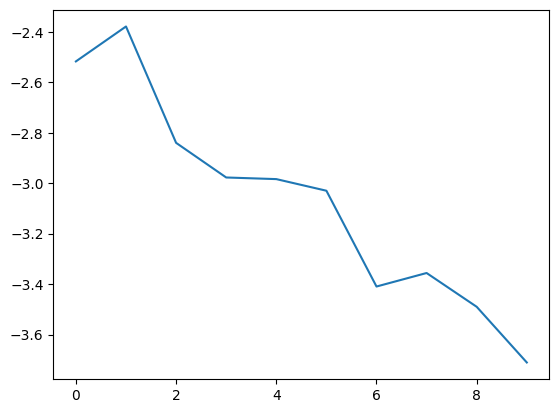

In [4]:
env = build_env()
rewards = []

env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    if truncated or terminated:
        break
env.close()

plt.plot(rewards)

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4.
Moviepy - Writing video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4


Moviepy - Done !
Moviepy - video ready /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4


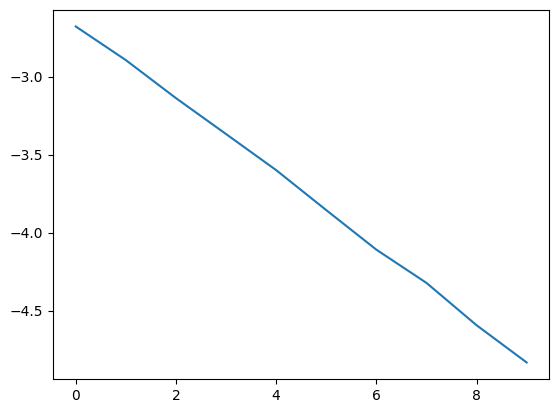

In [5]:
env = build_env()
rewards = []

phases = np.zeros(env.action_space.shape)  # (n,)
hip_phases = phases[0::2]
knee_phases = phases[1::2]
knee_phases[:len(knee_phases)//2] = -np.pi / 2

env.reset()
while True:
    # action = env.action_space.sample()
    action = phases
    obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    if truncated or terminated:
        break
env.close()

plt.plot(rewards)

# Now RL!

In [6]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output

In [7]:
use_cuda = torch.cuda.is_available()
if torch.has_mps:
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
device

device(type='mps')

In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [9]:
"""
Ornstein-Uhlenbeck process
Adding time-correlated noise to the actions taken by the deterministic policy
wiki (https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)
https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
"""
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.1, min_sigma=0.1, decay_period=15_000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    

In [10]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1][1]))
    iterations = [r[0] for r in rewards]
    episode_rewards = [r[1] for r in rewards]
    
    # Do mean averaging
    avg_len = 9
    episode_rewards = np.array(episode_rewards)
    episode_rewards = episode_rewards[:len(episode_rewards) - (len(episode_rewards) % avg_len)]
    episode_rewards = episode_rewards.reshape((len(episode_rewards) // avg_len, avg_len)).mean(axis=1)
    iterations = np.array(iterations)[::avg_len][:len(episode_rewards)]
    
    plt.plot(iterations, episode_rewards)
    plt.show()

In [11]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.tensor(state).unsqueeze(0).float().to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

In [12]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())


    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )


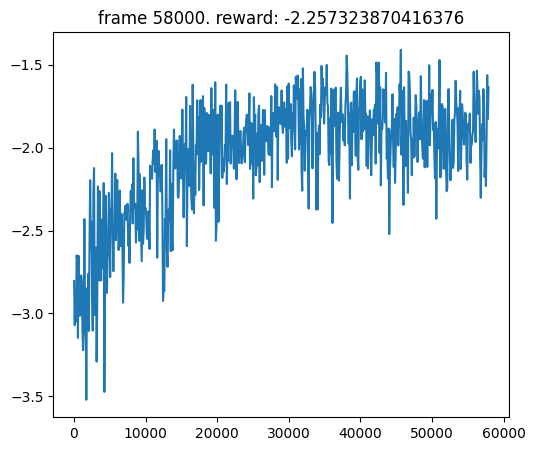

Moviepy - Building video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-2900000.mp4.
Moviepy - Writing video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-2900000.mp4


Moviepy - Done !
Moviepy - video ready /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-2900000.mp4


Moviepy - Building video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-2900000.mp4.
Moviepy - Writing video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-2900000.mp4


Moviepy - Done !
Moviepy - video ready /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-2900000.mp4


KeyboardInterrupt: 

In [13]:
env = build_env()

max_steps = 10
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 128

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
value_lr  = 1e-3
policy_lr = 1e-3

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 10_000
replay_buffer = ReplayBuffer(replay_buffer_size)

max_frames  = 100_000
frame_idx   = 0
rewards     = []
batch_size  = 1024

while frame_idx <= max_frames:
    state, _ = env.reset()
    ou_noise.reset()
    episode_reward = 0

    for step in range(max_steps):
        action = policy_net.get_action(state)
        action = ou_noise.get_action(action, step)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)

        state = next_state
        episode_reward += reward
        frame_idx += 1

        if frame_idx % max(100, max_steps + 1) == 0:
            plot(frame_idx, rewards)

        if done:
            break
    
    rewards.append((frame_idx, episode_reward / step))
    env.close()

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4.
Moviepy - Writing video /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4


Moviepy - Done !
Moviepy - video ready /Users/akhildevarashetti/code/reward_lab/exp/di/mujoco_exp/learning/_2_crawler/_0_random_target/agents/vids/simple_oscillating_phase-step-0.mp4


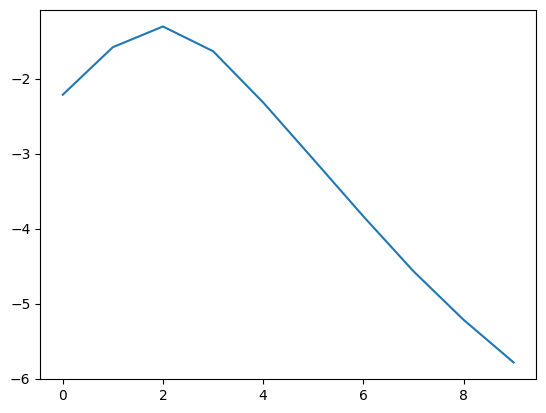

In [15]:
env = build_env()

rewards = []

state, _ = env.reset()
while True:
    # action = env.action_space.sample()
    action = policy_net.get_action(state)
    obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    if truncated or terminated:
        break
env.close()

plt.plot(rewards)